In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import ParameterGrid

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.ae_torch_classes import *

# Load in Data

In [2]:
# Kai's laptop
#data_path = 
#metadata_cols_df = pd.read_pickle('C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\metadata_cols_df.pkl')
# BRC Desktop
data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\filtered_datasets\\EMG_PPD\\"
metadata_cols_df = pd.read_pickle('D:\\Kai_MetaGestureClustering_24\\saved_datasets\\metadata_cols_df.pkl')

print("Loading")

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']

# Dropping the metadata when we read it in!
training_u_df = pd.read_pickle(data_path+'training_users_df.pkl').drop(metadata_cols, axis=1)
test_users_df = pd.read_pickle(data_path+'test_users_df.pkl').drop(metadata_cols, axis=1)

Loading


In [3]:
print(training_u_df.shape)
training_u_df.head()

(160000, 16)


,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [4]:
# CREATE THE TRAINING SET
num_rows_per_gesture = 64 # From the interp
num_gestures = len(training_u_df) // num_rows_per_gesture
num_features = training_u_df.shape[1]

# Ensure the data can be evenly divided into gestures
assert len(training_u_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns)
X_3D_PCA40 = training_u_df.to_numpy().reshape(num_gestures, num_rows_per_gesture, num_features)
#flattened_PCA = PCA_np.reshape(num_gestures, -1)

# Convert to PyTorch tensor
X_3DTensor_PCA40 = torch.tensor(X_3D_PCA40, dtype=torch.float32)

# Dummy dataset
#data = torch.randn(num_gestures, timesteps, num_features)
#dataset = TensorDataset(data)
#data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Create the dataset
u_training_dataset = GestureDatasetAE(X_3DTensor_PCA40)

batch_size = 32  # Adjust batch size as needed
train_loader = DataLoader(u_training_dataset, batch_size=batch_size, shuffle=True) # Should shuffle be False? 
## It's shuffling the gesture order I think so that should be fine...

# CREATE THE TEST SET
num_test_gestures = len(test_users_df) // num_rows_per_gesture
# Ensure the data can be evenly divided into gestures
assert len(test_users_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns) and convert to torch tensor
## Theres probably an easier way to just create it as a torch tensor lol
Xtest_3DTensor_PCA40 = torch.tensor(test_users_df.to_numpy().reshape(num_test_gestures, num_rows_per_gesture, num_features), dtype=torch.float32)

# Create the dataset
u_testing_dataset = GestureDatasetAE(Xtest_3DTensor_PCA40)
test_loader = DataLoader(u_testing_dataset, batch_size=batch_size, shuffle=False)

# RNN Autoencoder

In [5]:
# Example usage
input_dim = 16
#num_features = 40
seq_len = 64
#timesteps = 64
criterion = nn.MSELoss()
num_epochs = 10

## Manual Grid Search

Started
Epoch 0: Train Loss: 0.9368240969090522;  Validation Loss: 0.7768098468130286
Epoch 1: Train Loss: 0.7506836350960068;  Validation Loss: 0.6393506852063265
Epoch 2: Train Loss: 0.6457828834087034;  Validation Loss: 0.5576870400797237
Epoch 3: Train Loss: 0.5938962863970406;  Validation Loss: 0.5125259377739646
Epoch 4: Train Loss: 0.5596971681600884;  Validation Loss: 0.485479166561907
Epoch 5: Train Loss: 0.5351215921625306;  Validation Loss: 0.46477076004851947
Epoch 6: Train Loss: 0.518087383312515;  Validation Loss: 0.45057048174467956
Epoch 7: Train Loss: 0.5003282771080355;  Validation Loss: 0.4421637153083628
Epoch 8: Train Loss: 0.48799119342731523;  Validation Loss: 0.4342148967764594
Epoch 9: Train Loss: 0.47961664577073687;  Validation Loss: 0.4298047755252231


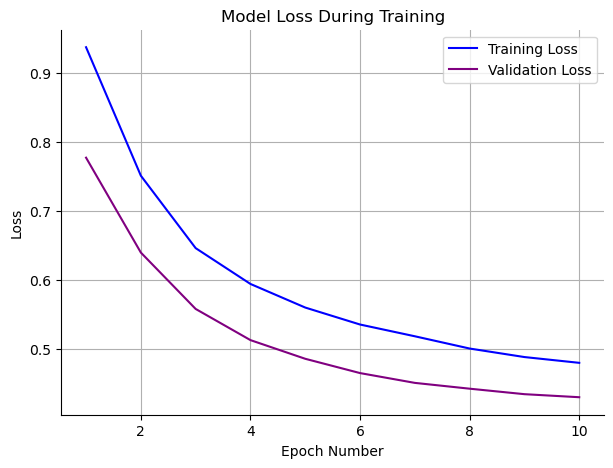

In [6]:
print("Started")

# Hyperparameters and dataset setup
num_layers = 3
lr = 0.001
hidden_dim = 16

# With progressive halving
model_16_nl3_prog, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim, num_layers, train_loader, test_loader, progressive_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.959057681168182;  Validation Loss: 0.8362765420566906
Epoch 1: Train Loss: 0.7881787638121014;  Validation Loss: 0.675981495868076
Epoch 2: Train Loss: 0.7139741069153894;  Validation Loss: 0.6283587474714626
Epoch 3: Train Loss: 0.6843141106110585;  Validation Loss: 0.6079372330145403
Epoch 4: Train Loss: 0.6700348959693426;  Validation Loss: 0.5968757502057336
Epoch 5: Train Loss: 0.660781676256204;  Validation Loss: 0.5896944146264683
Epoch 6: Train Loss: 0.653151862228973;  Validation Loss: 0.5847210694443096
Epoch 7: Train Loss: 0.6461340460596205;  Validation Loss: 0.5787286446853117
Epoch 8: Train Loss: 0.6370529245726669;  Validation Loss: 0.5719396052035418
Epoch 9: Train Loss: 0.6314048299306556;  Validation Loss: 0.5690180320631374


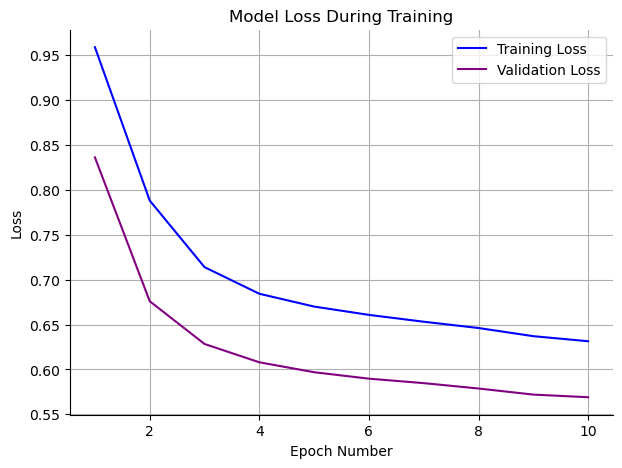

In [7]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001
hidden_dim_list = [16, 8, 4]

# With mirroring
model_16_8_4mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.9484632611274719;  Validation Loss: 0.8046182285655629
Epoch 1: Train Loss: 0.8205967062636267;  Validation Loss: 0.7387100972912528
Epoch 2: Train Loss: 0.7907087817976747;  Validation Loss: 0.7169450954957441
Epoch 3: Train Loss: 0.7422178546084633;  Validation Loss: 0.6322815729813143
Epoch 4: Train Loss: 0.692302592193024;  Validation Loss: 0.5954937013712797
Epoch 5: Train Loss: 0.6752660478217692;  Validation Loss: 0.5764902057972822
Epoch 6: Train Loss: 0.6641957865485663;  Validation Loss: 0.5664767961610447
Epoch 7: Train Loss: 0.6563414410699772;  Validation Loss: 0.5562740523706783
Epoch 8: Train Loss: 0.6533322538001628;  Validation Loss: 0.5509446588429537
Epoch 9: Train Loss: 0.6472745628296575;  Validation Loss: 0.5461332486434416


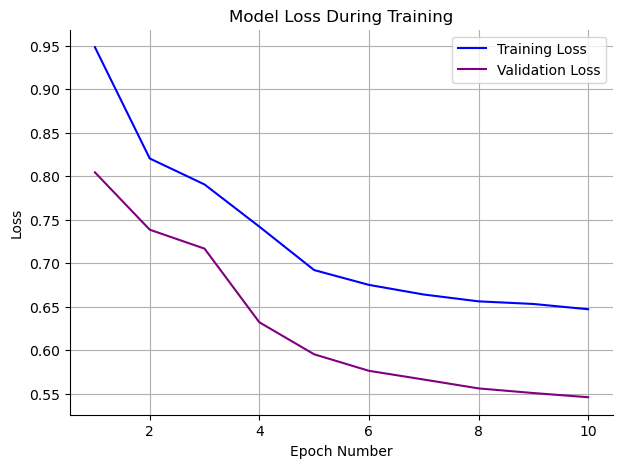

In [12]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [16, 8, 3]
model_16_8_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.9459210702135593;  Validation Loss: 0.8019656945358623
Epoch 1: Train Loss: 0.8238713801661625;  Validation Loss: 0.7420618588274176
Epoch 2: Train Loss: 0.7921021844767318;  Validation Loss: 0.7157714041796598
Epoch 3: Train Loss: 0.7335392319703404;  Validation Loss: 0.6175199787725102
Epoch 4: Train Loss: 0.6747968325132057;  Validation Loss: 0.5878016989339482
Epoch 5: Train Loss: 0.6516261070589476;  Validation Loss: 0.575490952892737
Epoch 6: Train Loss: 0.6354272742814655;  Validation Loss: 0.5645246465097774
Epoch 7: Train Loss: 0.617360956306699;  Validation Loss: 0.5585271174257452
Epoch 8: Train Loss: 0.604307398765902;  Validation Loss: 0.5508258329196409
Epoch 9: Train Loss: 0.5902252499061295;  Validation Loss: 0.5403027358380231


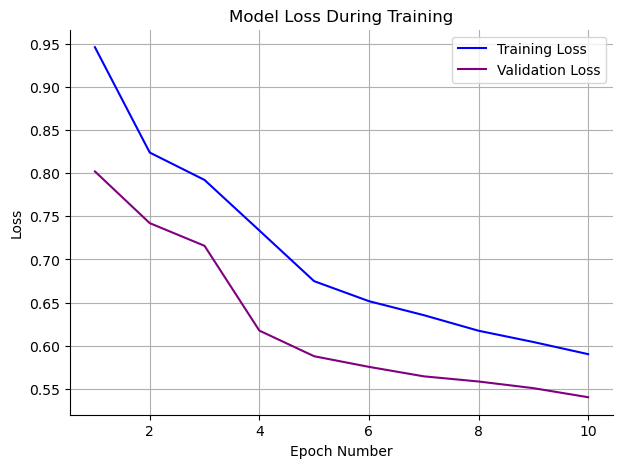

In [11]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [20, 14, 7, 3]
model_20_14_7_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.9542589768578734;  Validation Loss: 0.8533400188792836
Epoch 1: Train Loss: 0.7770654906200457;  Validation Loss: 0.6831630956042897
Epoch 2: Train Loss: 0.6386605169199691;  Validation Loss: 0.5623034211722288
Epoch 3: Train Loss: 0.5460551301889782;  Validation Loss: 0.47968839379874145
Epoch 4: Train Loss: 0.4772748788700828;  Validation Loss: 0.4200508472594348
Epoch 5: Train Loss: 0.4236832823179945;  Validation Loss: 0.3765990659594536
Epoch 6: Train Loss: 0.38315778065331374;  Validation Loss: 0.3422853391278874
Epoch 7: Train Loss: 0.34676740592039085;  Validation Loss: 0.31358760595321655
Epoch 8: Train Loss: 0.3150780250000048;  Validation Loss: 0.2924806076017293
Epoch 9: Train Loss: 0.29286323827278765;  Validation Loss: 0.2742025730284778


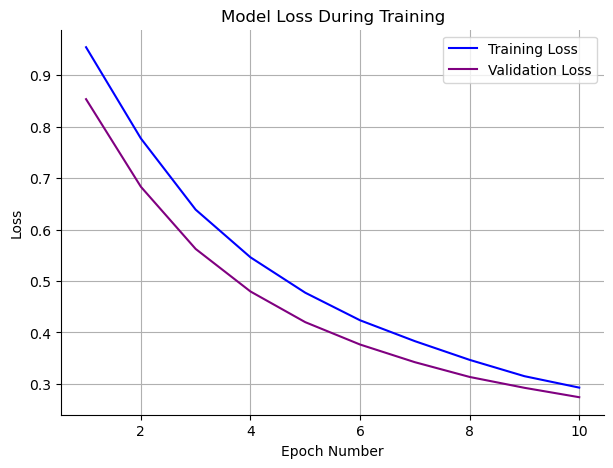

In [10]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [10]
model_10mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.9702636146847206;  Validation Loss: 0.8235591893846338
Epoch 1: Train Loss: 0.7638719179962254;  Validation Loss: 0.6504944237795743
Epoch 2: Train Loss: 0.632698607595661;  Validation Loss: 0.5515416007150303
Epoch 3: Train Loss: 0.5506163469598263;  Validation Loss: 0.4817383167418567
Epoch 4: Train Loss: 0.4856792869447153;  Validation Loss: 0.4237881031903354
Epoch 5: Train Loss: 0.43292174007319195;  Validation Loss: 0.3819512657143853
Epoch 6: Train Loss: 0.3958939989156361;  Validation Loss: 0.3495355532927947
Epoch 7: Train Loss: 0.364756951980953;  Validation Loss: 0.32329521395943384
Epoch 8: Train Loss: 0.34113205837298044;  Validation Loss: 0.29819752275943756
Epoch 9: Train Loss: 0.3187770854823197;  Validation Loss: 0.2774711867625063


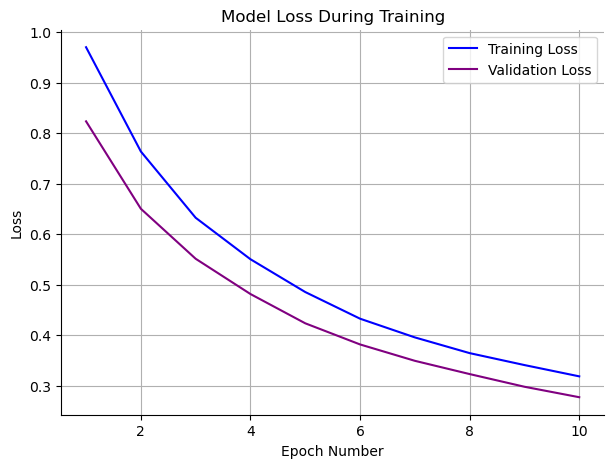

In [8]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [9]
model_9mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.9290512355068062;  Validation Loss: 0.8112721307711168
Epoch 1: Train Loss: 0.7810943534102621;  Validation Loss: 0.6713885962963104
Epoch 2: Train Loss: 0.6714743488951574;  Validation Loss: 0.5608584609898654
Epoch 3: Train Loss: 0.5872749784324742;  Validation Loss: 0.49153060940178955
Epoch 4: Train Loss: 0.5288485862031768;  Validation Loss: 0.4467054321007295
Epoch 5: Train Loss: 0.48272952814645403;  Validation Loss: 0.4046982472593134
Epoch 6: Train Loss: 0.43687897392466096;  Validation Loss: 0.3674369833686135
Epoch 7: Train Loss: 0.39712698022021525;  Validation Loss: 0.3386778567324985
Epoch 8: Train Loss: 0.364518533779096;  Validation Loss: 0.318095362321897
Epoch 9: Train Loss: 0.3460415465922295;  Validation Loss: 0.3034766194495288


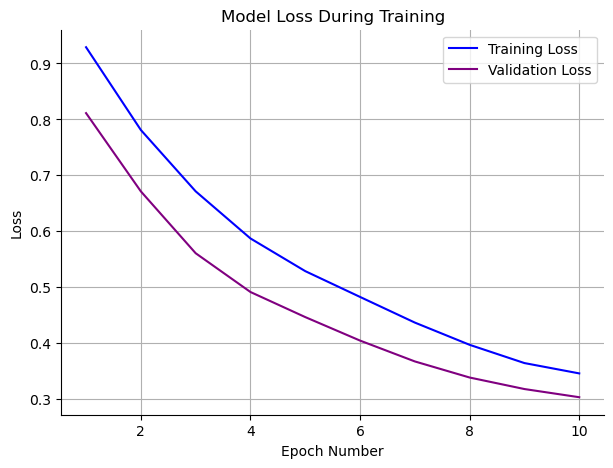

In [9]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [8]
model_8mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.9879663760149027;  Validation Loss: 0.899470947005532
Epoch 1: Train Loss: 0.8488896836208392;  Validation Loss: 0.7669056789441542
Epoch 2: Train Loss: 0.8012226571010638;  Validation Loss: 0.7322201810099862
Epoch 3: Train Loss: 0.7798257017437416;  Validation Loss: 0.7082429812713102
Epoch 4: Train Loss: 0.7572305021406729;  Validation Loss: 0.6946955512870442
Epoch 5: Train Loss: 0.7449397957777675;  Validation Loss: 0.6838140514763918
Epoch 6: Train Loss: 0.7324855636946762;  Validation Loss: 0.67812149903991
Epoch 7: Train Loss: 0.729798467098912;  Validation Loss: 0.6726978624408896
Epoch 8: Train Loss: 0.7199055763739574;  Validation Loss: 0.6747723370790482
Epoch 9: Train Loss: 0.7197616198394872;  Validation Loss: 0.6652482802217657


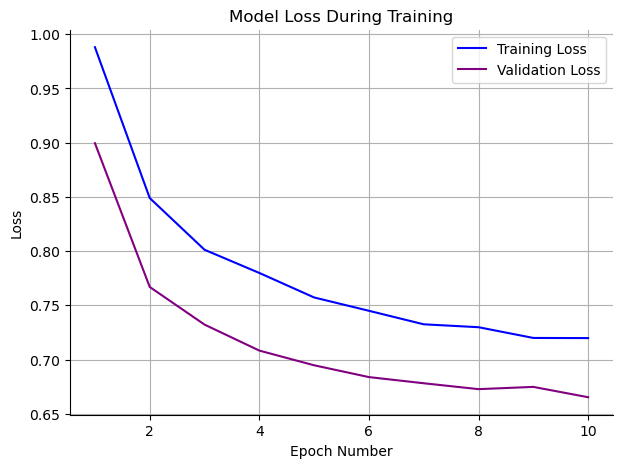

In [13]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [17, 15, 13, 11, 9, 7, 5, 3]
model_17_15_13_11_9_7_5_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.9467254741282403;  Validation Loss: 0.7831456363201141
Epoch 1: Train Loss: 0.7369173463386826;  Validation Loss: 0.6175614351576025
Epoch 2: Train Loss: 0.6239049744002426;  Validation Loss: 0.5389764620499178
Epoch 3: Train Loss: 0.5749246402631832;  Validation Loss: 0.5147113759409297
Epoch 4: Train Loss: 0.5551620570919181;  Validation Loss: 0.5005893443118442
Epoch 5: Train Loss: 0.5421651643288287;  Validation Loss: 0.4927667033943263
Epoch 6: Train Loss: 0.5313419477094578;  Validation Loss: 0.4843047098679976
Epoch 7: Train Loss: 0.5192591110362282;  Validation Loss: 0.47840800204060296
Epoch 8: Train Loss: 0.5100655031355121;  Validation Loss: 0.47089226069775497
Epoch 9: Train Loss: 0.5030275085304357;  Validation Loss: 0.46602555973963306


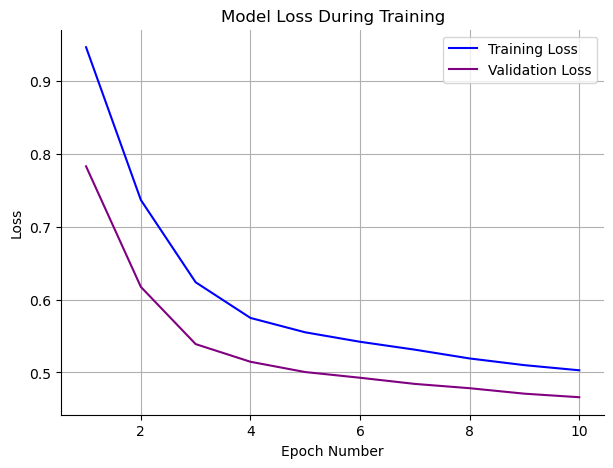

In [14]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [18, 12, 8]
model_18_12_8mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 1.0062420300290555;  Validation Loss: 0.9495745897293091
Epoch 1: Train Loss: 0.8689743982085699;  Validation Loss: 0.7367740923708136
Epoch 2: Train Loss: 0.735938042779512;  Validation Loss: 0.6247193190184507
Epoch 3: Train Loss: 0.6609046564826483;  Validation Loss: 0.5616000497883017
Epoch 4: Train Loss: 0.6188010890272599;  Validation Loss: 0.5328607193448327
Epoch 5: Train Loss: 0.5959734139563162;  Validation Loss: 0.5172145664691925
Epoch 6: Train Loss: 0.5807183037830305;  Validation Loss: 0.5067683607339859
Epoch 7: Train Loss: 0.56842946628981;  Validation Loss: 0.49660270051522687
Epoch 8: Train Loss: 0.5462632416924343;  Validation Loss: 0.47849370403723285
Epoch 9: Train Loss: 0.51850671104238;  Validation Loss: 0.46859096126122907


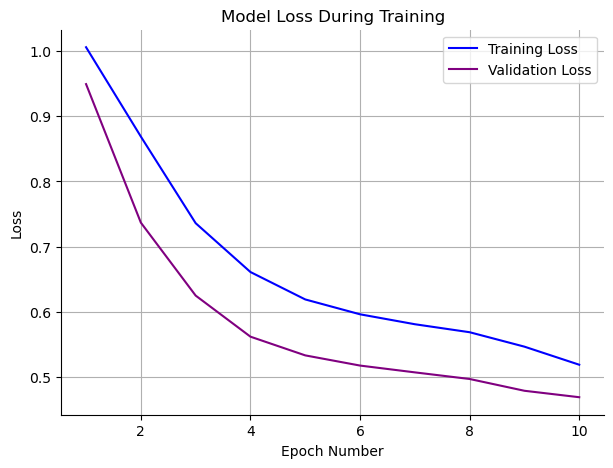

In [15]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [8, 6]
model_8_6mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.9752068904381764;  Validation Loss: 0.8769694539633665
Epoch 1: Train Loss: 0.7962457017053531;  Validation Loss: 0.6794809021733024
Epoch 2: Train Loss: 0.6576108872135983;  Validation Loss: 0.5826334723017432
Epoch 3: Train Loss: 0.5897534350051156;  Validation Loss: 0.528164653615518
Epoch 4: Train Loss: 0.5445464019533954;  Validation Loss: 0.4906501797112552
Epoch 5: Train Loss: 0.4994009676613385;  Validation Loss: 0.4467730915004557
Epoch 6: Train Loss: 0.46014983593663084;  Validation Loss: 0.41966644674539566
Epoch 7: Train Loss: 0.43531475527377067;  Validation Loss: 0.40231105482036417
Epoch 8: Train Loss: 0.41985769173766996;  Validation Loss: 0.39100605858997867
Epoch 9: Train Loss: 0.40898818532122844;  Validation Loss: 0.3806356205181642


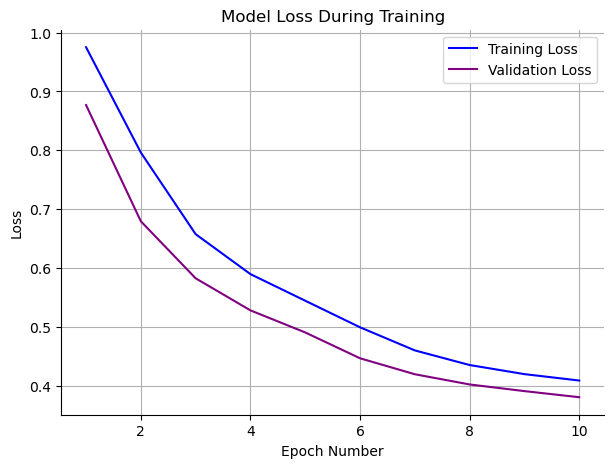

In [16]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [12, 6]
model_12_6mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

In [ ]:
assert(False)

Save a few of the above models

In [18]:
torch.save(model_20_14_7_3mir .state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\RNNAE_20_14_7_3mir_vallossp540_EMGFull.pth')
torch.save(model_9mir .state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\RNNAE_9mir_vallossp277_EMGFull.pth')
torch.save(model_12_6mir .state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\RNNAE_12_6mir_vallossp380_EMGFull.pth')